In [ ]:
# Install rpy2 to allow R integration within a Python env
!pip install -r /home/jupyter/requirements.txt

# Dependencies for openssl
!sudo apt-get update
!sudo apt-get install -y libssl-dev

%load_ext rpy2.ipython

In [2]:
%%R
# Install the 'remotes' package first
if (!require("remotes")) install.packages("remotes")

# Use 'remotes::install_version()' to install specific versions
if (!require("reticulate")) remotes::install_version("reticulate", version = "1.35.0")
if (!require("readxl")) remotes::install_version("readxl", version = "1.3.1")
if (!require("ggplot2")) remotes::install_version("ggplot2", version = "3.3.3")
if (!require("scales")) remotes::install_version("scales", version = "1.1.1")
if (!require("lubridate")) remotes::install_version("lubridate", version = "1.7.10")
if (!require("tidyverse")) remotes::install_version("tidyverse", version = "1.3.0")
if (!require("Robyn")) remotes::install_version("Robyn", version="3.10.3")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: remotes
Loading required package: reticulate
Loading required package: readxl
Loading required package: ggplot2
Use suppressPackageStartupMessages() to eliminate package startup
messages
Loading required package: scales
Loading required package: lubridate

Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.5     ✔ forcats 1.0.0
✔ purrr   1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ readr::col_factor()      masks scales::col_factor()
✖ lubridate::date()        masks base::date()
✖ purrr::discard()         masks scales::discard()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::

In [3]:
%%R
# Clear Workspace
rm(list=ls())

# Define Data Path
root        <- "/home/jupyter/mmm"
data_path   <- "Data"
models_path <- "Models"

# Define Input File Name
data.raw   <- "BA.xlsx"

# Sheets within The Data
sales.sheet  <- "sales"
ads.sheet    <- "media"
others.sheet <- "macros"

# Load Libraries
library(lubridate)
library(remotes)
library(tidyverse)
library(Robyn)
library(reticulate)

Sys.setenv(RETICULATE_PYTHON = "/opt/conda/bin/python3")

In [4]:
%%R
# Read Offline Data
setwd(paste(root))
robyn_directory <- paste(root, models_path, sep = "/")

sales.raw  <- read_excel(data.raw, sheet = sales.sheet)
ads.raw    <- read_excel(data.raw, sheet = ads.sheet)
macros.raw <- read_excel(data.raw, sheet = others.sheet)

# Clean-up
rm(data.raw, sales.sheet, ads.sheet, others.sheet)

# Convert dates
# Ensure the "Week Ending Sat" column is of the same type (Date) in all dataframes
sales.raw$`Week Ending Sat` <- as.Date(sales.raw$`Week Ending Sat`)
ads.raw$`Week Ending Sat` <- as.Date(ads.raw$`Week Ending Sat`)
macros.raw$`Week Ending Sat` <- as.Date(macros.raw$`Week Ending Sat`)

In [5]:
%%R

# Run summary statistics
# Business validation

# Summary of sales numbers (dollars, units, ASP) & comparison to last year

# Find the latest date in your data
latest_date <- max(sales.raw$`Week Ending Sat`)

# Separate data frames for latest 52 weeks and prior 52 weeks
latest_52_weeks <- sales.raw %>%
  filter(`Week Ending Sat` > latest_date - weeks(52) & `Week Ending Sat` <= latest_date)

prior_52_weeks <- sales.raw %>%
  filter(`Week Ending Sat` > latest_date - weeks(104) & `Week Ending Sat` <= latest_date - weeks(52))

# Summarize data
summarize_data <- function(data) {
  data %>%
    group_by(`Sales Source`) %>%
    summarize(Sales = sum(`Net Revenue (Sales)`),
              Non_Zero_Obs = sum(`Net Revenue (Sales)` != 0),
              .groups = 'drop')
}

# Apply summarization function
summary_latest = summarize_data(latest_52_weeks)
summary_prior = summarize_data(prior_52_weeks)

# Join the summaries and calculate percentage delta
summary_table <- full_join(summary_prior, summary_latest, by = "Sales Source", suffix = c("_Prior", "_Latest")) %>%
  mutate(Pct_Delta = (Sales_Latest - Sales_Prior) / Sales_Prior * 100)

# Arrange columns in the specified order
summary_table <- summary_table %>%
  select(`Sales Source`,
         Sales_Prior, Sales_Latest, Pct_Delta,
         Non_Zero_Obs_Prior, Non_Zero_Obs_Latest)

# Print the summary table
print(summary_table)

# A tibble: 2 × 6
  `Sales Source` Sales_Prior Sales_Latest Pct_Delta Non_Zero_Obs_Prior
  <chr>                <dbl>        <dbl>     <dbl>              <int>
1 AMA              88016166.    76511149.     -13.1                 52
2 IRI               1817798.    16437466.     804.                  40
# ℹ 1 more variable: Non_Zero_Obs_Latest <int>


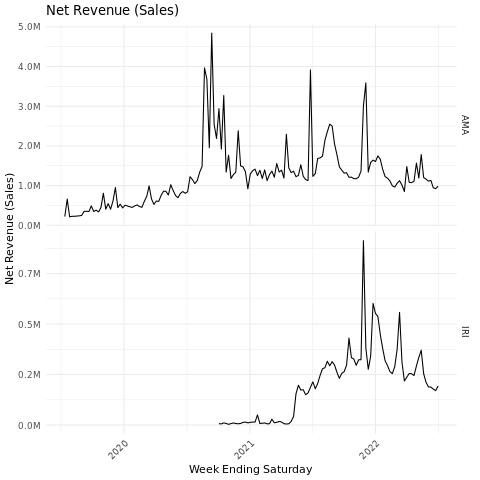

In [6]:
%%R
# Creating the plot
ggplot(sales.raw, aes(x = `Week Ending Sat`, y = `Net Revenue (Sales)`)) +
  geom_line() + # Line plot
  facet_grid(`Sales Source` ~ ., scales = "free_y") + # Facet by Source
  scale_y_continuous(labels = scales::label_number(scale = 1e-6, suffix = "M", accuracy = 0.1)) +
  theme_minimal() + # Minimal theme
  labs(title = "Net Revenue (Sales)",
       x = "Week Ending Saturday",
       y = "Net Revenue (Sales)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis labels for clarity


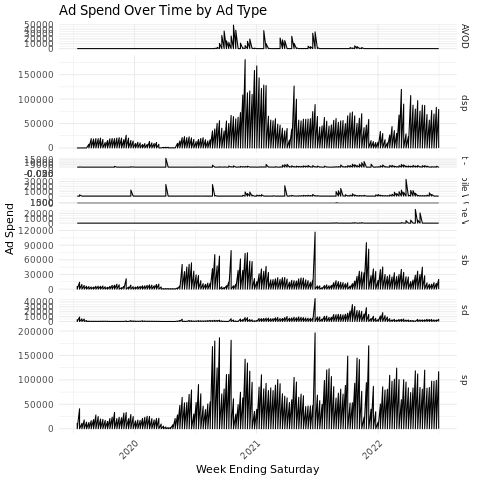

In [7]:
%%R
# Summary of advertising

# Arrange the data by "Week Ending Sat"
ads.raw <- ads.raw %>%
  arrange(`Week Ending Sat`)

# Create a complete sequence of weeks
all_weeks <- seq(from = min(ads.raw$`Week Ending Sat`), to = max(ads.raw$`Week Ending Sat`), by = "week")

# Expand the dataset to include all combinations of weeks, "Ad Type", and Media Group
ads.complete <- ads.raw %>%
  complete(`Week Ending Sat` = all_weeks, `Ad Type`, `Media Group`, fill = list(`Ad Spend` = 0))

# Creating the plot
ggplot(ads.complete, aes(x = `Week Ending Sat`, y = `Ad Spend`)) +
  geom_line() + # Line plot
  facet_grid(`Ad Type` ~ ., scales = "free_y", space = "free") + # Facet by "Ad Type"
  theme_minimal() + # Minimal theme
  labs(title = "Ad Spend Over Time by Ad Type",
       x = "Week Ending Saturday",
       y = "Ad Spend") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis labels for clarity

In [8]:
%%R
# Merge all raw data frames
# Pivot data
# Pivot the ads.raw data
ads.raw.wide <- ads.raw %>%
  select(`Week Ending Sat`, varname, `Ad Spend`, Impressions, Clicks, `Ad Attributed Sales on AMA`, `Ad Units from Kantar`) %>%
  pivot_wider(names_from = varname,
              values_from = c(`Ad Spend`, Impressions, Clicks, `Ad Attributed Sales on AMA`, `Ad Units from Kantar`),
              names_glue = "{varname}_{.value}") %>%
  arrange(`Week Ending Sat`)

# Merge the data frames
modelling_data <- sales.raw %>%
  left_join(ads.raw.wide, by = "Week Ending Sat") %>%
  left_join(macros.raw, by = "Week Ending Sat")

# set the dates to Sunday because of Robyn's inflexiability
modelling_data$`Week Ending Sun` <- modelling_data$`Week Ending Sat` + 1


In [9]:
%%R
# Missing values
modelling_data[is.na(modelling_data)] <- 0

# Remove spaces
names(modelling_data) <- gsub(" ", "_", names(modelling_data))

# View the merged data frame
head(modelling_data)

# Separate out each Sales Source into it's own dataframe
# Create the first dataframe for "Source1"
modeling_data_ama <- modelling_data %>%
  filter(Sales_Source == "AMA")

# Create the second dataframe for "Source2"
modeling_data_others <- modelling_data %>%
  filter(Sales_Source == "IRI")

# End Read & Validate Data


In [10]:
%%R

packageVersion("Robyn")

## Force multi-core use when running RStudio
Sys.setenv(R_FUTURE_FORK_ENABLE = "true")
options(future.fork.enable = TRUE)

# Set to FALSE to avoid the creation of files locally
create_files <- TRUE

## All sign control are now automatically provided: "positive" for media & organic
## variables and "default" for all others. User can still customise signs if necessary.
## Documentation is available, access it anytime by running: ?robyn_inputs
modeling_data_ama <- modeling_data_ama %>%
  rename(Net_Revenue_Sales = `Net_Revenue_(Sales)`)

paid_media_spends = names(modeling_data_ama)[grepl("_Ad_Spend$", names(modeling_data_ama))]
paid_media_spends <- paid_media_spends[paid_media_spends != "mobileApp_Ad_Spend"]

paid_media_vars = names(modeling_data_ama)[grepl("_Ad_Spend$", names(modeling_data_ama))]
paid_media_vars <- paid_media_vars[paid_media_vars != "mobileApp_Ad_Spend"]

modeling_data_ama$Avg_Sales_Price <-
  modeling_data_ama$Net_Revenue_Sales / modeling_data_ama$Sold_Units

InputCollect <- robyn_inputs(
  dt_input = modeling_data_ama,
  #dt_holidays = dt_prophet_holidays,
  date_var = "Week_Ending_Sun", # date format must be "2020-01-01"
  dep_var = "Net_Revenue_Sales", # there should be only one dependent variable
  dep_var_type = "revenue", # "revenue" (ROI) or "conversion" (CPA)
  prophet_vars = c("trend", "season", "holiday"), # "trend","season", "weekday" & "holiday"
  prophet_country = "US", # input country code. Check: dt_prophet_holidays
  context_vars = c("Avg_Sales_Price", "Total_Organic_Impressions_On_AMA"), # e.g. competitors, discount, unemployment etc
  paid_media_spends = paid_media_spends, # mandatory input
  paid_media_vars = paid_media_vars, # mandatory.
  # paid_media_vars must have same order as paid_media_spends. Use media exposure metrics like
  # impressions, GRP etc. If not applicable, use spend instead.
  #organic_vars = "Avg_Sales_Price", # marketing activity without media spend
  # factor_vars = c("events"), # force variables in context_vars or organic_vars to be categorical
  window_start = min(modeling_data_ama$Week_Ending_Sun),
  window_end = max(modeling_data_ama$Week_Ending_Sun),
  adstock = "geometric" # geometric, weibull_cdf or weibull_pdf.
)
print(InputCollect)

#### 2a-2: Second, define and add hyperparameters

## Default media variable for modelling has changed from paid_media_vars to paid_media_spends.
## Also, calibration_input are required to be spend names.
## hyperparameter names are based on paid_media_spends names too. See right hyperparameter names:
hyper_names(adstock = InputCollect$adstock, all_media = InputCollect$all_media)

## Guide to setup & understand hyperparameters

## Robyn's hyperparameters have four components:
## - Adstock parameters (theta or shape/scale)
## - Saturation parameters (alpha/gamma)
## - Regularisation parameter (lambda). No need to specify manually
## - Time series validation parameter (train_size)

## 1. IMPORTANT: set plot = TRUE to create example plots for adstock & saturation
## hyperparameters and their influence in curve transformation.
plot_adstock(plot = F)
plot_saturation(plot = F)

## 2. Get correct hyperparameter names:
# All variables in paid_media_spends and organic_vars require hyperparameter and will be
# transformed by adstock & saturation.
# Run hyper_names(adstock = InputCollect$adstock, all_media = InputCollect$all_media)
# to get correct media hyperparameter names. All names in hyperparameters must equal
# names from hyper_names(), case sensitive. Run ?hyper_names to check function arguments.

## 3. Hyperparameter interpretation & recommendation:

## Geometric adstock: Theta is the only parameter and means fixed decay rate. Assuming TV
# spend on day 1 is 100€ and theta = 0.7, then day 2 has 100*0.7=70€ worth of effect
# carried-over from day 1, day 3 has 70*0.7=49€ from day 2 etc. Rule-of-thumb for common
# media genre: TV c(0.3, 0.8), OOH/Print/Radio c(0.1, 0.4), digital c(0, 0.3). Also,
# to convert weekly to daily we can transform the parameter to the power of (1/7),
# so to convert 30% daily to weekly is 0.3^(1/7) = 0.84.

## 4. Set individual hyperparameter bounds. They either contain two values e.g. c(0, 0.5),
# or only one value, in which case you'd "fix" that hyperparameter.
# Run hyper_limits() to check maximum upper and lower bounds by range
hyper_limits()

# Merge the vectors
hyperparameters_ranges <- list("alphas" = c(0.5, 3),
                               "gammas" = c(0.3, 1),
                               "thetas" = c(0, 0.3))

# Merge the list of ranges with the variable names
hyperparameters <- lapply(paid_media_vars, function(v) {
  setNames(
    lapply(names(hyperparameters_ranges), function(n) hyperparameters_ranges[[n]]),
    paste(v, names(hyperparameters_ranges), sep = "_")
  )
})

hyperparameters <- do.call(c, hyperparameters)

hyperparameters <- c(hyperparameters, list('train_size' = c(0.5, 0.8)))

#### 2a-3: Third, add hyperparameters into robyn_inputs()
InputCollect <- robyn_inputs(InputCollect = InputCollect, hyperparameters = hyperparameters)
print(InputCollect)

#### Check spend exposure fit if available
if (length(InputCollect$exposure_vars) > 0) {
  lapply(InputCollect$modNLS$plots, plot)
}


################################################################
#### Step 3: Build initial model

## Run all trials and iterations. Use ?robyn_run to check parameter definition
OutputModels <- robyn_run(
  InputCollect = InputCollect, # feed in all model specification
  cores = NULL, # NULL defaults to (max available - 1)
  iterations = 1000, # 2000 recommended for the dummy dataset with no calibration
  trials = 3, # 5 recommended for the dummy dataset
  ts_validation = FALSE, # 3-way-split time series for NRMSE validation.
  add_penalty_factor = FALSE # Experimental feature. Use with caution.
)
print(OutputModels)

## Check MOO (multi-objective optimization) convergence plots
# Read more about convergence rules: ?robyn_converge
OutputModels$convergence$moo_distrb_plot
OutputModels$convergence$moo_cloud_plot

## Check time-series validation plot (when ts_validation == TRUE)
# Read more and replicate results: ?ts_validation
if (OutputModels$ts_validation) OutputModels$ts_validation_plot

## Calculate Pareto fronts, cluster and export results and plots. See ?robyn_outputs
OutputCollect <- robyn_outputs(
  InputCollect, OutputModels,
  pareto_fronts = "auto", # automatically pick how many pareto-fronts to fill min_candidates (100)
  # min_candidates = 100, # top pareto models for clustering. Default to 100
  # calibration_constraint = 0.1, # range c(0.01, 0.1) & default at 0.1
  csv_out = "pareto", # "pareto", "all", or NULL (for none)
  clusters = TRUE, # Set to TRUE to cluster similar models by ROAS. See ?robyn_clusters
  export = create_files, # this will create files locally
  plot_folder = robyn_directory, # path for plots exports and files creation
  plot_pareto = create_files # Set to FALSE to deactivate plotting and saving model one-pagers
)
print(OutputCollect)

################################################################
#### Step 4: Select and save the any model

## Compare all model one-pagers and select one that mostly reflects your business reality
print(OutputCollect)

sort(OutputCollect$allSolutions)
OutputCollect$clusters$models$solID
OutputCollect$clusters$models$mape
OutputCollect$clusters$models$decomp.rssd
OutputCollect$clusters$models$nrmse
OutputCollect$clusters$models$nrmse_test
OutputCollect$clusters$models$nrmse_train
# Print summary stats of all the Pareto models

select_model <- "2_64_9" # Pick one of the models from OutputCollect to proceed

#### Version >=3.7.1: JSON export and import (faster and lighter than RDS files)
ExportedModel <- robyn_write(InputCollect, OutputCollect, select_model, export = create_files)
print(ExportedModel)

ExportedModel$ExportedModel$errors$rsq_train

# To plot any model's one-pager:
myOnePager <- robyn_onepagers(InputCollect, OutputCollect, select_model, export = FALSE)

# To check each of the one-pager's plots
myOnePager[[select_model]]$patches$plots[[1]]
myOnePager[[select_model]]$patches$plots[[2]]
myOnePager[[select_model]]$patches$plots[[3]]
myOnePager[[select_model]]$patches$plots[[4]]
myOnePager[[select_model]]$patches$plots[[5]]
myOnePager[[select_model]]$patches$plots[[6]]
myOnePager[[select_model]]$patches$plots[[7]]

Total Observations: 156 (weeks)
Input Table Columns (104):
  Date: Week_Ending_Sun
  Dependent: Net_Revenue_Sales [revenue]
  Paid Media: dsp_Ad_Spend, sb_Ad_Spend, sd_Ad_Spend, sp_Ad_Spend, internetDisplay_Ad_Spend, mobileWeb_Ad_Spend, avod_Ad_Spend, onlineVideo_Ad_Spend, mobileWebVideo_Ad_Spend
  Paid Media Spend: dsp_Ad_Spend, sb_Ad_Spend, sd_Ad_Spend, sp_Ad_Spend, internetDisplay_Ad_Spend, mobileWeb_Ad_Spend, avod_Ad_Spend, onlineVideo_Ad_Spend, mobileWebVideo_Ad_Spend
  Context: Avg_Sales_Price, Total_Organic_Impressions_On_AMA
  Organic: 
  Prophet (Auto-generated): trend, season, holiday on US
  Unused variables: Brand_Name, Sales_Source, Week_Ending_Sat, Latest_Year, Sold_Units, Retail_Price, Gross_Revenue_.Sales., units_sold_source_promo, Total_Discount, Number_of_Transactions, Average_AMA_Star_Ratings, Total_Searches_On_AMA, Total_Unique_Searches_On_AMA, Total_Unique_Branded_Organic_Searches_On_AMA, Total_Clicks_On_AMA, Total_Impressions_On_AMA, Total_Ops_On_AMA, Avg_Search_P

RInterpreterError: Failed to parse and evaluate line '\npackageVersion("Robyn")\n\n## Force multi-core use when running RStudio\nSys.setenv(R_FUTURE_FORK_ENABLE = "true")\noptions(future.fork.enable = TRUE)\n\n# Set to FALSE to avoid the creation of files locally\ncreate_files <- TRUE\n\n## All sign control are now automatically provided: "positive" for media & organic\n## variables and "default" for all others. User can still customise signs if necessary.\n## Documentation is available, access it anytime by running: ?robyn_inputs\nmodeling_data_ama <- modeling_data_ama %>%\n  rename(Net_Revenue_Sales = `Net_Revenue_(Sales)`)\n\npaid_media_spends = names(modeling_data_ama)[grepl("_Ad_Spend$", names(modeling_data_ama))]\npaid_media_spends <- paid_media_spends[paid_media_spends != "mobileApp_Ad_Spend"]\n\npaid_media_vars = names(modeling_data_ama)[grepl("_Ad_Spend$", names(modeling_data_ama))]\npaid_media_vars <- paid_media_vars[paid_media_vars != "mobileApp_Ad_Spend"]\n\nmodeling_data_ama$Avg_Sales_Price <-\n  modeling_data_ama$Net_Revenue_Sales / modeling_data_ama$Sold_Units\n\nInputCollect <- robyn_inputs(\n  dt_input = modeling_data_ama,\n  #dt_holidays = dt_prophet_holidays,\n  date_var = "Week_Ending_Sun", # date format must be "2020-01-01"\n  dep_var = "Net_Revenue_Sales", # there should be only one dependent variable\n  dep_var_type = "revenue", # "revenue" (ROI) or "conversion" (CPA)\n  prophet_vars = c("trend", "season", "holiday"), # "trend","season", "weekday" & "holiday"\n  prophet_country = "US", # input country code. Check: dt_prophet_holidays\n  context_vars = c("Avg_Sales_Price", "Total_Organic_Impressions_On_AMA"), # e.g. competitors, discount, unemployment etc\n  paid_media_spends = paid_media_spends, # mandatory input\n  paid_media_vars = paid_media_vars, # mandatory.\n  # paid_media_vars must have same order as paid_media_spends. Use media exposure metrics like\n  # impressions, GRP etc. If not applicable, use spend instead.\n  #organic_vars = "Avg_Sales_Price", # marketing activity without media spend\n  # factor_vars = c("events"), # force variables in context_vars or organic_vars to be categorical\n  window_start = min(modeling_data_ama$Week_Ending_Sun),\n  window_end = max(modeling_data_ama$Week_Ending_Sun),\n  adstock = "geometric" # geometric, weibull_cdf or weibull_pdf.\n)\nprint(InputCollect)\n\n#### 2a-2: Second, define and add hyperparameters\n\n## Default media variable for modelling has changed from paid_media_vars to paid_media_spends.\n## Also, calibration_input are required to be spend names.\n## hyperparameter names are based on paid_media_spends names too. See right hyperparameter names:\nhyper_names(adstock = InputCollect$adstock, all_media = InputCollect$all_media)\n\n## Guide to setup & understand hyperparameters\n\n## Robyn\'s hyperparameters have four components:\n## - Adstock parameters (theta or shape/scale)\n## - Saturation parameters (alpha/gamma)\n## - Regularisation parameter (lambda). No need to specify manually\n## - Time series validation parameter (train_size)\n\n## 1. IMPORTANT: set plot = TRUE to create example plots for adstock & saturation\n## hyperparameters and their influence in curve transformation.\nplot_adstock(plot = F)\nplot_saturation(plot = F)\n\n## 2. Get correct hyperparameter names:\n# All variables in paid_media_spends and organic_vars require hyperparameter and will be\n# transformed by adstock & saturation.\n# Run hyper_names(adstock = InputCollect$adstock, all_media = InputCollect$all_media)\n# to get correct media hyperparameter names. All names in hyperparameters must equal\n# names from hyper_names(), case sensitive. Run ?hyper_names to check function arguments.\n\n## 3. Hyperparameter interpretation & recommendation:\n\n## Geometric adstock: Theta is the only parameter and means fixed decay rate. Assuming TV\n# spend on day 1 is 100€ and theta = 0.7, then day 2 has 100*0.7=70€ worth of effect\n# carried-over from day 1, day 3 has 70*0.7=49€ from day 2 etc. Rule-of-thumb for common\n# media genre: TV c(0.3, 0.8), OOH/Print/Radio c(0.1, 0.4), digital c(0, 0.3). Also,\n# to convert weekly to daily we can transform the parameter to the power of (1/7),\n# so to convert 30% daily to weekly is 0.3^(1/7) = 0.84.\n\n## 4. Set individual hyperparameter bounds. They either contain two values e.g. c(0, 0.5),\n# or only one value, in which case you\'d "fix" that hyperparameter.\n# Run hyper_limits() to check maximum upper and lower bounds by range\nhyper_limits()\n\n# Merge the vectors\nhyperparameters_ranges <- list("alphas" = c(0.5, 3),\n                               "gammas" = c(0.3, 1),\n                               "thetas" = c(0, 0.3))\n\n# Merge the list of ranges with the variable names\nhyperparameters <- lapply(paid_media_vars, function(v) {\n  setNames(\n    lapply(names(hyperparameters_ranges), function(n) hyperparameters_ranges[[n]]),\n    paste(v, names(hyperparameters_ranges), sep = "_")\n  )\n})\n\nhyperparameters <- do.call(c, hyperparameters)\n\nhyperparameters <- c(hyperparameters, list(\'train_size\' = c(0.5, 0.8)))\n\n#### 2a-3: Third, add hyperparameters into robyn_inputs()\nInputCollect <- robyn_inputs(InputCollect = InputCollect, hyperparameters = hyperparameters)\nprint(InputCollect)\n\n#### Check spend exposure fit if available\nif (length(InputCollect$exposure_vars) > 0) {\n  lapply(InputCollect$modNLS$plots, plot)\n}\n\n\n################################################################\n#### Step 3: Build initial model\n\n## Run all trials and iterations. Use ?robyn_run to check parameter definition\nOutputModels <- robyn_run(\n  InputCollect = InputCollect, # feed in all model specification\n  cores = NULL, # NULL defaults to (max available - 1)\n  iterations = 1000, # 2000 recommended for the dummy dataset with no calibration\n  trials = 3, # 5 recommended for the dummy dataset\n  ts_validation = FALSE, # 3-way-split time series for NRMSE validation.\n  add_penalty_factor = FALSE # Experimental feature. Use with caution.\n)\nprint(OutputModels)\n\n## Check MOO (multi-objective optimization) convergence plots\n# Read more about convergence rules: ?robyn_converge\nOutputModels$convergence$moo_distrb_plot\nOutputModels$convergence$moo_cloud_plot\n\n## Check time-series validation plot (when ts_validation == TRUE)\n# Read more and replicate results: ?ts_validation\nif (OutputModels$ts_validation) OutputModels$ts_validation_plot\n\n## Calculate Pareto fronts, cluster and export results and plots. See ?robyn_outputs\nOutputCollect <- robyn_outputs(\n  InputCollect, OutputModels,\n  pareto_fronts = "auto", # automatically pick how many pareto-fronts to fill min_candidates (100)\n  # min_candidates = 100, # top pareto models for clustering. Default to 100\n  # calibration_constraint = 0.1, # range c(0.01, 0.1) & default at 0.1\n  csv_out = "pareto", # "pareto", "all", or NULL (for none)\n  clusters = TRUE, # Set to TRUE to cluster similar models by ROAS. See ?robyn_clusters\n  export = create_files, # this will create files locally\n  plot_folder = robyn_directory, # path for plots exports and files creation\n  plot_pareto = create_files # Set to FALSE to deactivate plotting and saving model one-pagers\n)\nprint(OutputCollect)\n\n################################################################\n#### Step 4: Select and save the any model\n\n## Compare all model one-pagers and select one that mostly reflects your business reality\nprint(OutputCollect)\n\nsort(OutputCollect$allSolutions)\nOutputCollect$clusters$models$solID\nOutputCollect$clusters$models$mape\nOutputCollect$clusters$models$decomp.rssd\nOutputCollect$clusters$models$nrmse\nOutputCollect$clusters$models$nrmse_test\nOutputCollect$clusters$models$nrmse_train\n# Print summary stats of all the Pareto models\n\nselect_model <- "2_64_9" # Pick one of the models from OutputCollect to proceed\n\n#### Version >=3.7.1: JSON export and import (faster and lighter than RDS files)\nExportedModel <- robyn_write(InputCollect, OutputCollect, select_model, export = create_files)\nprint(ExportedModel)\n\nExportedModel$ExportedModel$errors$rsq_train\n\n# To plot any model\'s one-pager:\nmyOnePager <- robyn_onepagers(InputCollect, OutputCollect, select_model, export = FALSE)\n\n# To check each of the one-pager\'s plots\nmyOnePager[[select_model]]$patches$plots[[1]]\nmyOnePager[[select_model]]$patches$plots[[2]]\nmyOnePager[[select_model]]$patches$plots[[3]]\nmyOnePager[[select_model]]$patches$plots[[4]]\nmyOnePager[[select_model]]$patches$plots[[5]]\nmyOnePager[[select_model]]$patches$plots[[6]]\nmyOnePager[[select_model]]$patches$plots[[7]]\n'.
R error message: 'Error in robyn_write(InputCollect, OutputCollect, select_model, export = create_files) : \n  select_model %in% OutputCollect$allSolutions is not TRUE'
R stdout:
>> Running feature engineering...
Input data has 156 weeks in total: 2019-07-14 to 2022-07-03
Initial model is built on rolling window of 156 week: 2019-07-14 to 2022-07-03
Fitting time series with all available data...
Using geometric adstocking with 29 hyperparameters (28 to iterate + 1 fixed) with no parallel computation
>>> Starting 3 trials with 1000 iterations each using TwoPointsDE nevergrad algorithm...
  Running trial 1 of 3
  Running trial 2 of 3
  Running trial 3 of 3
- DECOMP.RSSD NOT converged: sd@qt.20 0.16 > 0.074 & |med@qt.20| 0.39 > 0.081
- NRMSE NOT converged: sd@qt.20 0.016 > 0.014 & |med@qt.20| 0.081 <= 0.13
Total run time: 5.49 mins
WARNING: Provided 'plot_folder' doesn't exist. Using current working directory: /home/jupyter/mmm
>>> Running Pareto calculations for 3000 models on auto fronts...
>> Automatically selected 3 Pareto-fronts to contain at least 100 pareto-optimal models (117)
>>> Calculating response curves for all models' media variables (1053)...
>> Pareto-Front: 1 [35 models]
>> Pareto-Front: 2 [36 models]
>> Pareto-Front: 3 [46 models]
>>> Calculating clusters for model selection using Pareto fronts...
>> Auto selected k = 5 (clusters) based on minimum WSS variance of 5%
>>> Collecting 117 pareto-optimum results into: /home/jupyter/mmm/Robyn_202402100315_init/
>> Exporting general plots into directory...
>> Exporting pareto results as CSVs into directory...
>>> Exporting pareto one-pagers into directory...
>> Generating only cluster results one-pagers (5)...
>> Plotting 5 selected models on 1 cores...
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: rngtools
>> Exported model inputs as /home/jupyter/mmm/Robyn_202402100315_init/RobynModel-inputs.json
Error in robyn_write(InputCollect, OutputCollect, select_model, export = create_files) : 
  select_model %in% OutputCollect$allSolutions is not TRUE
In addition: Warning messages:
1: In check_iteration(InputCollect$calibration_input, iterations, trials,  :
  We recommend to run at least 2000 iterations per trial and 5 trials to build initial model
2: In hyper_collector(InputCollect, hyper_in = InputCollect$hyperparameters,  :
  Provided train_size but ts_validation = FALSE. Time series validation inactive.
3: In .font_global(font, quiet = FALSE) :
  Font 'Arial Narrow' is not installed, has other name, or can't be found
4: In geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01,  :
  Ignoring unknown parameters: `size`